# Fixed Point Step Functions.

Convert the algorithm for generating steps in the article ["Generate stepper-motor speed profiles in real time"](https://www.embedded.com/generate-stepper-motor-speed-profiles-in-real-time/) into a Fixed Point version. 

The key formula from the article is:

<img src="https://www.embedded.com/wp-content/uploads/media-1042023-0501feat1eq13.gif">

To make this function work in fixed point, we multiply both sides by a fixed point factor, $\alpha$:

1. $c_i = c_{i-1} - \frac{2c_{i-1}}{4n_i+1}$
1. $c_i\alpha = {\alpha}c_{i-1} - \alpha\frac{2c_{i-1}}{4n_i+1}$
1. ${\alpha}c_i = {\alpha}c_{i-1} - \frac{{\alpha}2c_{i-1}}{4n_i+1}$

Let $c_{\alpha} = {\alpha}c_{i-1}$

${\alpha}c_i = c_{\alpha} - \frac{2c_{\alpha}}{4n_i+1}$

With assignment notation:

$c_{\alpha} \leftarrow c_{\alpha} - \frac{2c_{\alpha}}{4n_i+1}$

In [1]:
from trajectory import SimSegment as ss
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
n, cn,ca = ss.initial_params(0,1000,1)
n, cn, ca, ca>>8

(0, 0.03023163905579716, 0, 0)

In [29]:
from math import log, sqrt
TIMEBASE=1_000_000 # Counter an delays are measures in 1/TIMEBASE secs
FP_BITS = 8 # Number of fraction bits in fixed point representation of cn


def initial_params(v0, v1, t, timebase=None):
    """Set initial parameters, which are a bit different for the first step,
    to account for low torque. """

    # If n is positive, there is a non zero velocity and we are accelerating
    # If it is negative, there is a non zero velocity and we are decelerating

    timebase = timebase if timebase is not None else TIMEBASE

    v0 = float(v0)
    v1 = float(v1)

    if v0 == 0 and v1 == 0:
        # Going nowhere.
        n = 0
        cn = 0

    elif v0 == 0:
        # Starting from a stop, so need special
        # first delay.
        a = abs(v1) / t
        n = 0  # n will always be positive, so accelerating
        cn = 0.676 * sqrt(2.0 / a) * timebase  # c0 in Equation 15
        
        assert cn > 0

    elif v0 == v1:
        # Constant velocity.
        n = N_BIG
        cn = timebase / abs(v0)
    else:
        # Normal case, between two non-zero velocities
        a = abs(v1 - v0) / t
        n = (v0 * v0) / (2.0 * a)  # Equation 16
        cn = timebase / abs(v0)

        assert n >= 0

        # Need to put the sign back on n; n must be negative for deceleration
        if abs(v1) < abs(v0):
            n = -n

   
    # Fixed point version of cn
    ca = int(cn)<<FP_BITS
  
    n = int(n)

    return n, cn, ca

def next_params(n, cn):

    n += 1

    if cn != 0:
        cn = cn - ((2.0 * cn) / ((4.0 * n) + 1)) # Equation 13

    return int(n), cn

def next_params_xp(n, ca):
    """Fixed point version of the next_params function"""

    n += 1

    if n != 0:
         ca = (ca - ((ca << 1) / ((n << 2) + 1)))  # Equation 13

    
    return n, int(abs(ca))

def next_params_bres(n,ca):
    pass
    

def simulate(v0, v1, t):
    
    n, cn, ca = initial_params(v0,v1,t, timebase=TIMEBASE)
   
    yield n, cn, ca, ca>>FP_BITS
    
    x = abs(.5 * (v1 + v0) * t)
    
    for i in range(int(x)):
        _, ca = next_params_xp(n, ca)
        n, cn = next_params(n, cn)
        
        yield n,cn, ca, ca>>FP_BITS
     

df = pd.DataFrame(list(simulate(80,10000,1)), columns='n cn car ca'.split())
df['ca1'] = df.car - df.car.shift(-1) 
df['d'] = (df.cn-df.ca).abs()
df['cum_d'] = df.d.cumsum()
df['cum_cn'] = df.cn.cumsum()
df['pct_err'] = (df.d.cumsum() / df.cn.cumsum() * 100).round(3)
print(df.cn.max(), round(log(df.cn.max())/log(2)), df.pct_err.max() )
display(df.head())
df.tail()

    

12500.0 14 1.453


,n,cn,car,ca,ca1,d,cum_d,cum_cn,pct_err
0,0,12500.000000,3200000,12500,1280000.0,0.000000,0.000000,12500.000000,0.000
1,1,7500.000000,1920000,7500,426667.0,0.000000,0.000000,20000.000000,0.000
2,2,5833.333333,1493333,5833,229744.0,0.333333,0.333333,25833.333333,0.001
3,3,4935.897436,1263589,4935,148658.0,0.897436,1.230769,30769.230769,0.004
4,4,4355.203620,1114931,4355,106184.0,0.203620,1.434389,35124.434389,0.004


,n,cn,car,ca,ca1,d,cum_d,cum_cn,pct_err
5036,5036,130.281539,31659,123,4.0,7.281539,18961.088069,1.306141e+06,1.452
5037,5037,130.268608,31655,123,4.0,7.268608,18968.356677,1.306271e+06,1.452
5038,5038,130.255680,31651,123,4.0,7.255680,18975.612356,1.306402e+06,1.453
5039,5039,130.242756,31647,123,4.0,7.242756,18982.855112,1.306532e+06,1.453
5040,5040,130.229835,31643,123,NaN,7.229835,18990.084947,1.306662e+06,1.453


In [14]:

cn

800.0

In [109]:
INTERRUPT_PERIOD = 5 #NUmber of TIMEBASE ticks for each update of the Bresenham line update. 
from fractions import Fraction

def next_params_bres(n,cn):
    f  = TIMEBASE/cn

    intr_per_step = cn/INTERRUPT_PERIOD
    r = round((1/intr_per_step)*1000,0)
    
    return intr_per_step, r
    
f = 10_000 + 121
n, cn, ca = initial_params(f, f+1,1)
s, r = next_params_bres(n,cn)
s, r

(19.760893192372297, 51.0)

In [59]:
%%time
errors = set()
for i in range(1,2000):
    for j in range(1,2000):
        r = float(i)/float(j)
        f = Fraction(i,j).limit_denominator(100)
        errors.add(abs(r-f))

CPU times: user 59.7 s, sys: 126 ms, total: 59.8 s
Wall time: 1min


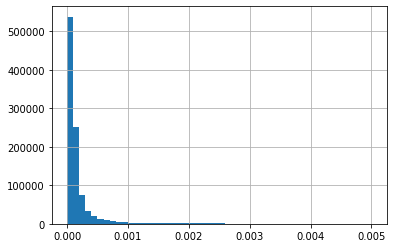

In [65]:
s = pd.Series(list(errors))
s.hist(bins=50)

In [94]:
1/Fraction(13,17)

Fraction(17, 13)

CPU times: user 564 ms, sys: 3.26 ms, total: 567 ms
Wall time: 566 ms


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7faed0c3c9b0>,
      dtype=object)

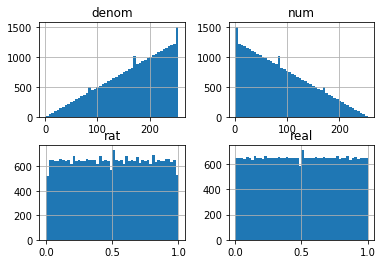

In [89]:
%%time

nums = []
for i in range(1,256):
    for j in range(1,i):
        r = float(j)/float(i)
        f = Fraction(j,i).limit_denominator(100)
        nums.append([j,i,float(f), r])
        
s = pd.DataFrame(list(nums), columns = 'num denom rat real'.split())

s.hist(bins=50)

In [85]:
s.describe()

,num,denom,real,rat
count,32385.000000,32385.000000,32385.000000,32385.000000
mean,85.333333,170.666667,0.500000,0.500000
std,59.986110,59.986110,0.286443,0.286452
min,1.000000,2.000000,0.000000,0.003922
25%,35.000000,128.000000,0.252525,0.251969
50%,75.000000,181.000000,0.500000,0.500000
75%,128.000000,221.000000,0.747475,0.748031
max,254.000000,255.000000,1.000000,0.996078


In [91]:
s.rat.nunique()

3045

In [104]:
5544/4000


1.386